# Hospital Readmission Prediction

### A hospital readmission is when a patient who is discharged from a hospital, gets re-admitted again within a certain period of time. Readmission rates for certain conditions are now considered an indicator of hospital quality, and also affect the cost of care adversely. Being able to determine factors that lead to higher readmission in such patients, and correspondingly being able to predict which patients will get readmitted can help hospitals save millions of dollars while improving quality of care. So, with that background in mind, we build models to predict the readmission rate 

#### Dataset -> https://archive.ics.uci.edu/ml/datasets/diabetes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.svm import LinearSVC
import warnings
warnings.filterwarnings('ignore')

### Column Info

- encounter_id : Patient encounter ID
- patient_nbr : Patient nbr code                
- race : Race                           
- gender : Gender                     
- age : Age in categories                            
- weight : Weight                         
- admission_type_id : admission id          
- discharge_disposition_id : dishacharge id       
- admission_source_id  : source id           
- time_in_hospital : time spent in hospital             
- payer_code  : payer code
- medical_specialty : Medical Specialty
- diag_1 : diagnosis 1
- diag_2 : diagnosis 2
- diag_3 : diagnosis 3
- number_diagnoses : Total diagnosis
- max_glu_serum  : Max Gluten level
- A1Cresult  : A1 test results
- Medication change for Different Drugs : (metformin ,repaglinide,nateglinide  chlorpropamide glimepiride acetohexamide glipizide glyburide tolbutamide pioglitazone rosiglitazone acarbose miglitol troglitazone tolazamine examide citoglipton insulin glyburide-metform glipizide-metformin glimepiride-pioglitazone  metformin-rosiglitazone metformin-pioglitone )
- diabetesMed : Diabetic Medication
- readmitted : Patient Readmiited or not

### Data Pre Processing

In [2]:
df = pd.read_csv("diabetic_data.csv")
print("DF Shape : " +str(df.shape))
print("Unique Values By Column")
print(df.nunique())

DF Shape : (101766, 50)
Unique Values By Column
encounter_id                101766
patient_nbr                  71518
race                             6
gender                           3
age                             10
weight                          10
admission_type_id                8
discharge_disposition_id        26
admission_source_id             17
time_in_hospital                14
payer_code                      18
medical_specialty               73
num_lab_procedures             118
num_procedures                   7
num_medications                 75
number_outpatient               39
number_emergency                33
number_inpatient                21
diag_1                         717
diag_2                         749
diag_3                         790
number_diagnoses                16
max_glu_serum                    4
A1Cresult                        4
metformin                        4
repaglinide                      4
nateglinide                      4
chlorpr

In [3]:
# Find the nulk and na values in the columns 
print("NA Values? ",df.isna().values.any())
print("Null Values? ",df.isnull().values.any())

totalRows = df.shape[0]

#Most of the columns have ? in the dataset
#Count the number of ? in each column

print('---No of ? as percent of total rows---')
for c in df.columns:
    val= df[c]=="?"
    print(c,df[c][val].count() , str(round((df[c][val].count()/totalRows)*100, 2)),"%")

# The columns 'weight','payer_code','medical_specialty' have more than 40% of values as "?" so drop them

NA Values?  False
Null Values?  False
---No of ? as percent of total rows---
encounter_id 0 0.0 %
patient_nbr 0 0.0 %
race 2273 2.23 %
gender 0 0.0 %
age 0 0.0 %
weight 98569 96.86 %
admission_type_id 0 0.0 %
discharge_disposition_id 0 0.0 %
admission_source_id 0 0.0 %
time_in_hospital 0 0.0 %
payer_code 40256 39.56 %
medical_specialty 49949 49.08 %
num_lab_procedures 0 0.0 %
num_procedures 0 0.0 %
num_medications 0 0.0 %
number_outpatient 0 0.0 %
number_emergency 0 0.0 %
number_inpatient 0 0.0 %
diag_1 21 0.02 %
diag_2 358 0.35 %
diag_3 1423 1.4 %
number_diagnoses 0 0.0 %
max_glu_serum 0 0.0 %
A1Cresult 0 0.0 %
metformin 0 0.0 %
repaglinide 0 0.0 %
nateglinide 0 0.0 %
chlorpropamide 0 0.0 %
glimepiride 0 0.0 %
acetohexamide 0 0.0 %
glipizide 0 0.0 %
glyburide 0 0.0 %
tolbutamide 0 0.0 %
pioglitazone 0 0.0 %
rosiglitazone 0 0.0 %
acarbose 0 0.0 %
miglitol 0 0.0 %
troglitazone 0 0.0 %
tolazamide 0 0.0 %
examide 0 0.0 %
citoglipton 0 0.0 %
insulin 0 0.0 %
glyburide-metformin 0 0.0 %
glip

In [4]:
# Also drop other unnecassary columns such as encounterid and patient nbr
# drop examide and citoglipton since they have same values
droppedColumns =['encounter_id','patient_nbr','weight','payer_code','medical_specialty','citoglipton','examide']
df = df.drop(droppedColumns, axis = 1)
df = df[df.gender != "Unknown/Invalid"] #since gender has few invalid values

#Dropping rows with ? in race
df = df[df.race != "?"] #since gender has few invalid values

#Dropping max_glu_serum and A1Cresult since 90% of the values are None 

#Removing other unnecassry columns with id values which does not relate to readmission prediction
df=df.drop(['max_glu_serum','A1Cresult','admission_type_id','discharge_disposition_id','admission_source_id',
           'diag_1','diag_2','diag_3'], axis = 1)

### Replacing the categorical values by numeric values
##### There is no ordinal relationship within these variables. 
##### Using get_dummies to perform One Hot encoding and dropping one of the columns from the encoded features to avoid multi collinearity

In [5]:
df = pd.get_dummies(data=df, columns=['change', 'gender','diabetesMed'], drop_first=True) 
#drop_first=True --> drops one of the column from the encoded features

In [6]:
#Recoding the outcome variable. 
#Whether the patient is readmitted within 30 days or not.#There are 3 categories, < 30, > 30 and No.
#To reduce this to a binary classification, we combine readmission after 30 days and no readmission into one category:
df['readmitted'] = df['readmitted'].map({'<30': 1, '>30':0, 'NO':0})

# Similarly encoded different drugs with numerical values
                                        
#Replacing Categorical Values with Numerical Values with one hod encoding
drugsNames = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
        'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide','pioglitazone',
        'rosiglitazone','acarbose','miglitol','troglitazone','tolazamide',
        'insulin','glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone','metformin-pioglitazone',
        'metformin-rosiglitazone']

for drug in drugsNames:
    df[drug] = df[drug].map({'Steady': 1, 'Up':1, 'Down':1, 'No': 0})

#### Splitting Age into different categories and converting it into numerical values

In [7]:
# Mapping ages to different categories
ageByCategories = {'[0-10)':'kids', 
                   '[10-20)':'teens', 
                   '[20-30)':'adults', '[30-40)':'adults', '[40-50)':'adults', '[50-60)':'adults', 
                   '[60-70)':'elderly', '[70-80)':'elderly', '[80-90)':'elderly', '[90-100)':'elderly'}
df['age'] = df['age'].map(ageByCategories)
#Converting Race and Age which are categorical into numerical values
df = pd.get_dummies(data=df, columns=['race','age'], drop_first=True)

### Box plot to show distrubution of values in the numerical columns

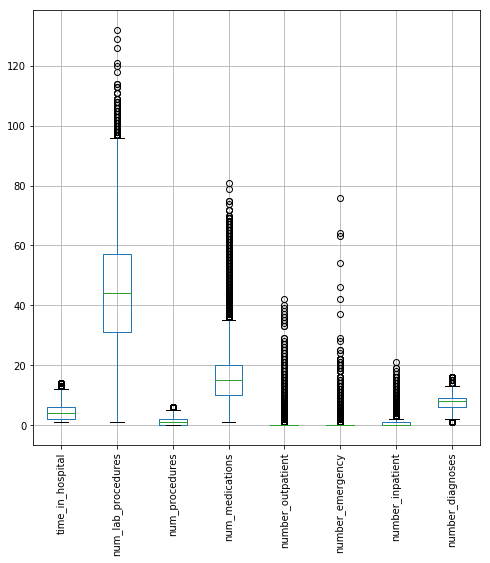

Shape after removing outlier is  (65484, 40)


In [8]:
numericalColumns = ['time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient',
                   'number_emergency','number_inpatient','number_diagnoses']
allColumns = df.columns
categoricalColumns = []
for c in allColumns:
    if c not in numericalColumns:
        categoricalColumns.append(c)
        df[c] = df[c].astype('object')
categoricalColumns.remove('readmitted')

boxplot = df.boxplot(column=numericalColumns,rot=90,fontsize=10,figsize=(8,8))
plt.show()
#This shows the outliers in each column and outliers has to be removed
df_Copy=df
for c in numericalColumns:
    col = df_Copy[c]
    d = df_Copy[col.between(col.quantile(.05), col.quantile(.95))] # without outliers
    df_Copy=d
print("Shape after removing outlier is ",d.shape)

In [9]:
d.describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,65484.000000,65484.000000,65484.000000,65484.000000,65484.000000,65484.000000,65484.000000,65484.000000
mean,3.965137,42.602666,1.042178,14.656847,0.153564,0.074889,0.452599,7.524265
std,2.391782,16.121749,1.342620,5.530388,0.448699,0.263213,0.773019,1.702148
min,1.000000,3.000000,0.000000,5.000000,0.000000,0.000000,0.000000,4.000000
25%,2.000000,33.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,3.000000,44.000000,0.000000,14.000000,0.000000,0.000000,0.000000,8.000000
75%,5.000000,55.000000,2.000000,18.000000,0.000000,0.000000,1.000000,9.000000
max,11.000000,72.000000,5.000000,28.000000,2.000000,1.000000,3.000000,9.000000


### Correlation Matrix

###### This shows that there is no correlation among the numerical columns and thereby inicates no multicollinearity in the data set

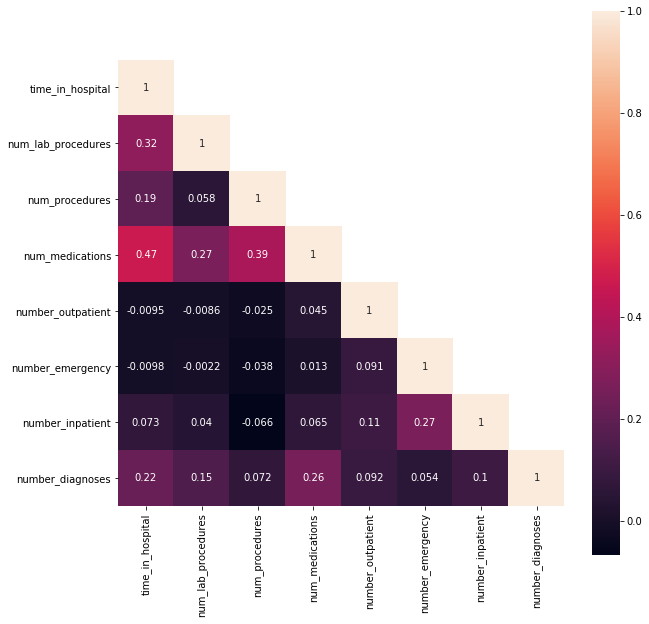

In [10]:
corr_df = df[numericalColumns]
cor_mat = corr_df.corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig = plt.gcf()
fig.set_size_inches(10,10)
sns.heatmap(data=cor_mat, mask=mask, square=True, annot=True, cbar=True)
plt.show()

### Cross Validation Train-Test Split

In [11]:
x = d.drop(['readmitted'],axis=1)
y = d['readmitted']
y=y.astype('int')

In [12]:
#Using minmax scaler to perform scaling on the numerical columns.Also the data is not normally distributed 
#Each numerical features are now on a common range from 0 to 1

scaler = MinMaxScaler()

x_train_org, x_test_org, y_train, y_test = train_test_split(x,y,random_state=0)

x_train_new = scaler.fit_transform(x_train_org[numericalColumns])
x_train_arr = np.concatenate((x_train_new, x_train_org[categoricalColumns]), axis=1)
x_train = pd.DataFrame(data=x_train_arr, columns=x_train_org.columns)

x_test_new = scaler.transform(x_test_org[numericalColumns])
x_test_arr = np.concatenate((x_test_new, x_test_org[categoricalColumns]), axis=1)
x_test = pd.DataFrame(data=x_test_arr, columns=x_test_org.columns)


x_train[numericalColumns] = x_train[numericalColumns].apply(pd.to_numeric)
x_test[numericalColumns] = x_test[numericalColumns].apply(pd.to_numeric)


## MODEL BUILDING

## Logistic Regression

In [31]:
logreg = LogisticRegression(solver='liblinear')
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_test)
y_pred_train = logreg.predict(x_train)
print("Logistic Accuracy Train:",metrics.accuracy_score(y_train, y_pred_train))
print("Logistic Accuracy Test :",metrics.accuracy_score(y_test, y_pred))

Logistic Accuracy Train: 0.8957302547187099
Logistic Accuracy Test : 0.8932258261560075


### Logisitic Regression with GridSearch CV

In [32]:
c_space = np.logspace(0,5,10)
param_grid = {'C': c_space}
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)
logreg_cv.fit(x_train,y_train)
print('Best value of C in Logistic Regression is ' + str(logreg_cv.best_params_))
print("Best Accuracy of the model when C is " + str(logreg_cv.best_params_)+ " is " + str(logreg_cv.best_score_))
log_new = logreg_cv.best_estimator_

Best value of C in Logistic Regression is {'C': 1.0}
Best Accuracy of the model when C is {'C': 1.0} is 0.8957302547187099


#### Cross Validation

In [33]:
train_scores = cross_val_score(log_new, x_train, y_train, cv = 5)
test_scores = log_new.score(x_test, y_test)
print('Train score: {:.4f}'.format(train_scores.mean()))
print('Test score: {:.4f}'.format(test_scores.mean()))

Train score: 0.8957
Test score: 0.8932


## KNN Classifier

KNN Accuracy Train: 0.8957302547187099
KNN Accuracy Test: 0.8688534603872702


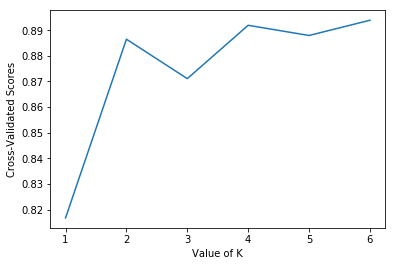

In [34]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
y_pred_train = logreg.predict(x_train)
print("KNN Accuracy Train:",metrics.accuracy_score(y_train, y_pred_train))
print("KNN Accuracy Test:",metrics.accuracy_score(y_test, y_pred))

k_scores=[]
k_range = range(1,7)
for k in k_range:
    knn= KNeighborsClassifier(n_neighbors=k)
    k_scores.append(cross_val_score(knn,x,y,cv=3).mean())

plt.plot(k_range,k_scores)
plt.xlabel('Value of K')
plt.ylabel('Cross-Validated Scores')
plt.show()

### KNN with GridSearch CV

In [35]:
param_grid = {'n_neighbors': [1,2,3,4,5,6],
              "weights" : ["uniform","distance"]
             }
knn_cv= GridSearchCV(KNeighborsClassifier(), param_grid, cv=3, n_jobs=-1, verbose=1)
knn_cv.fit(x,y)
print("Best value of K in K neighbors is " + str(knn_cv.best_params_))
print("Best Accuracy of the model when k is " + str(knn_cv.best_params_)+ " is " + str(knn_cv.best_score_))
knn_new = knn_cv.best_estimator_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  2.4min finished


Best value of K in K neighbors is {'n_neighbors': 6, 'weights': 'uniform'}
Best Accuracy of the model when k is {'n_neighbors': 6, 'weights': 'uniform'} is 0.8938672042025533


#### Cross Validation

In [36]:
train_scores = cross_val_score(knn_new, x_train, y_train, cv = 4)
test_scores = knn_new.score(x_test, y_test)
print('Train score: {:.4f}'.format(train_scores.mean()))
print('Test score: {:.4f}'.format(test_scores.mean()))

Train score: 0.8940
Test score: 0.8932


## Decision Tree Classifier

In [37]:
clf = DecisionTreeClassifier()
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
y_pred_train = clf.predict(x_train)
print("Decision Tree Train Accuracy:",metrics.accuracy_score(y_train, y_pred_train))
print("Decision Tree Test Accuracy:",metrics.accuracy_score(y_test, y_pred))

Decision Tree Train Accuracy: 0.9993891637651946
Decision Tree Test Accuracy: 0.7943314397410054


### Decision Tree Classifier with Gridsearch CV

In [38]:
tree_para = {'criterion':['gini','entropy'],
             'max_depth': range(1,20,2),
             'min_samples_split': [2, 3, 4]
            }
clf_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), tree_para, verbose=1, cv=3)
clf_cv.fit(x_train, y_train)

# Single best score achieved across all params (min_samples_split)
print(clf_cv.best_score_)

# Dictionary containing the parameter to generate that score
print(clf_cv.best_params_)

# Actual model object fit with those best parameters
print(clf_cv.best_estimator_)
clf_new = clf_cv.best_estimator_

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.8957302547187099
{'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 2}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   46.1s finished


#### Cross Validation

In [39]:
train_scores = cross_val_score(clf_new, x_train, y_train, cv = 4)
test_scores = clf_new.score(x_test, y_test)
print('Train score: {:.4f}'.format(train_scores.mean()))
print('Test score: {:.4f}'.format(test_scores.mean()))

Train score: 0.8957
Test score: 0.8932


## Support Vector Machines

In [40]:
svclinear = SVC(kernel='linear')
svclinear.fit(x_train, y_train)
y_pred = svclinear.predict(x_test)
print("SVM (Linear) Accuracy :",metrics.accuracy_score(y_test, y_pred))

SVM (Linear) Accuracy : 0.8932258261560075


In [41]:
svcpoly = SVC(kernel='poly', degree=3, gamma='auto')
svcpoly.fit(x_train, y_train)
y_pred = svcpoly.predict(x_test)
print("SVM (poly) Accuracy:",metrics.accuracy_score(y_test, y_pred))

SVM (poly) Accuracy: 0.8932258261560075


In [42]:
svcrbf = SVC(kernel='rbf', gamma=1, C=1)
svcrbf.fit(x_train, y_train)
y_pred = svcrbf.predict(x_test)
print("SVM (rbf) Accuracy:",metrics.accuracy_score(y_test, y_pred))

SVM (rbf) Accuracy: 0.8932258261560075


In [ ]:
svc_param_grid = {'C': [0.1,1,10], 
                  'gamma': [0.1,1,10],
                  'kernel': ['rbf', 'poly','linear']}

svc_cv = GridSearchCV(SVC(),svc_param_grid ,verbose=1, n_jobs=-1)
svc_cv.fit(x_train,y_train)
print("Best score achieved across all params  ", svc_cv.best_score_)
print("Best Parameters " ,svc_cv.best_params_)
print("Best SVM estimator ", svc_cv.best_estimator_)
svm_new = svc_cv.best_estimator_     

Fitting 3 folds for each of 27 candidates, totalling 81 fits


C:\Users\saran\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


#### Cross Validation

In [17]:
train_scores = cross_val_score(svc_cv, x_train, y_train, cv = 3)
test_scores = svc_cv.score(x_test, y_test)
print('Train score: {:.4f}'.format(train_scores.mean()))
print('Test score: {:.4f}'.format(test_scores.mean()))

Train score: 0.8957
Test score: 0.8932


In [13]:
param_grid = {'C':[0.01, 0.1, 1, 10, 100, 1000]}

linearSVC_grid = GridSearchCV(LinearSVC(), 
                     param_grid, cv =5 , return_train_score= True,scoring = 'f1_macro', iid = False)
linearSVC_grid.fit(x_train, y_train)
print(linearSVC_grid.best_params_)
print(linearSVC_grid.best_score_)

{'C': 100}
0.47539252891824757


### Conclusion

#### The Logistic Regression, KNN and SVM models have a good accuracy scores around 89%when comapred to decision tree classifier which only has a test accuracy of 79.3% . The best model would be KNN with 6 neighbors and uniform weights since it has an accuracy of 89.38 %